In [1]:
# CELL 1 — Imports & settings
# Purpose: set up libraries, inputs, color/style theme, and output folder for saved images.

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ---- INPUTS ----
CSV_PATH = r"C:\Users\Vex\Desktop\main\dataset\matchday\clean_matchday_stat.csv"  # source stats CSV
TEAM_A = "Bayer Leverkusen"  # left-side team for panels
TEAM_B = "Bayern Munich"     # right-side team for panels

# Where to save images (created if missing)
OUTPUT_DIR = "efficiency_panels_split"  # folder for per-team, per-matchday PNGs
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Colors (SWAPPED per your request)
BG_BAR = "#E6E8EB"        # light grey base bar (background rails)
LEV_COLOR = "#222222"     # Leverkusen = black/dark (fill)
BAY_COLOR = "#dc052d"     # Bayern = red (fill)
TEXT_LIGHT = "#FFFFFF"    # text color over dark fill
TEXT_DARK = "#1A1A1A"     # text color over light fill

# Matplotlib global style (crisper figures + consistent font)
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 12,
    "font.family": "DejaVu Sans"
})


In [2]:
# CELL 2 — Helpers
# Purpose: numeric cleaning, safe division, date parsing, and row role helpers.

def _clean_num(v):
    # Convert strings like '54%' or '1,234' to numeric; returns NaN if invalid
    if isinstance(v, str):
        v = v.replace('%', '').replace(',', '').strip()
    return pd.to_numeric(v, errors='coerce')

def _safe_div(n, d, eps=1e-9):
    """Safe divide that handles scalars and Series; returns NaN for tiny/zero denom."""
    # Vectorized path
    if isinstance(n, (pd.Series, np.ndarray)) or isinstance(d, (pd.Series, np.ndarray)):
        n = pd.to_numeric(n, errors='coerce')
        d = pd.to_numeric(d, errors='coerce')
        out = n.astype(float) / d.astype(float)
        mask = d.abs() < eps
        out[mask | n.isna() | d.isna()] = np.nan
        return out
    # Scalar path
    n = pd.to_numeric(n, errors='coerce')
    d = pd.to_numeric(d, errors='coerce')
    if pd.isna(n) or pd.isna(d) or abs(float(d)) < eps:
        return np.nan
    return float(n) / float(d)

def _parse_match_dt(row):
    """
    Build a true datetime from:
      - season '2023/2024'
      - Date_day like '18.05' or '18-05'
      - Date_hour like '16:30'
    Bundesliga season flip: Jul–Dec → start year; Jan–May → start year + 1.
    """
    day_month = str(row.get("Date_day", "")).replace("-", ".").strip()
    hhmm = (str(row.get("Date_hour", "00:00")).strip() or "00:00")

    # Split to (day, month) with robust fallbacks
    if "." in day_month:
        d_str, m_str = day_month.split(".", 1)
    else:
        parts = [p for p in day_month.split() if p]
        d_str, m_str = (parts + ["1","7"])[:2]

    # Coerce to ints with defaults
    try:
        d = int(float(d_str)); m = int(float(m_str))
    except Exception:
        d, m = 1, 7

    # Resolve year from season + month
    season = str(row.get("season_year", "2023/2024"))
    start_year = int(season.split("/")[0]) if "/" in season else 2023
    year = start_year if m >= 7 else start_year + 1

    # Build datetime; fallback clamps invalid day/month
    try:
        return datetime.strptime(f"{year:04d}-{m:02d}-{d:02d} {hhmm}", "%Y-%m-%d %H:%M")
    except Exception:
        return datetime(year, max(1,min(12,m)), max(1,min(28,d)), 0, 0)

def _rows_for_team_pair(row, team_name):
    """Return ('Home' or 'Host', 'Host' or 'Home') for (our_side, opp_side) used in keyed columns."""
    if row["home_team"] == team_name:
        return "Home", "Host"
    elif row["away_team"] == team_name:
        return "Host", "Home"
    else:
        return None, None


In [3]:
# CELL 3 — Build chronological per-team tables
# Purpose: extract each team's matches in time order and compute basic per-match fields.

df = pd.read_csv(CSV_PATH)

def build_team_raw(df, team_name):
    records = []
    for _, row in df.iterrows():
        side, opp = _rows_for_team_pair(row, team_name)
        if side is None:
            continue  # row not involving the team

        # Pick correct columns based on home/away side
        goals       = _clean_num(row["home_score" if side=="Home" else "away_score"])
        xg          = _clean_num(row["expected_goals_xg_home" if side=="Home" else "expected_goals_xg_host"])
        xga         = _clean_num(row["expected_goals_xg_host" if side=="Home" else "expected_goals_xg_home"])
        poss        = _clean_num(row["Ball_Possession_" + side])
        poss_opp    = _clean_num(row["Ball_Possession_" + opp])
        total_pass  = _clean_num(row["Total_Passes_" + side])
        comp_pass   = _clean_num(row["Completed_Passes_" + side])
        sog_against = _clean_num(row["Shots_on_Goal_" + opp])      # opponent SoT (our goal faced)
        saves       = _clean_num(row["Goalkeeper_Saves_" + side])   # our saves

        records.append({
            "match_dt": _parse_match_dt(row),
            "opponent": row["away_team" if side=="Home" else "home_team"],
            "venue": "Home" if side=="Home" else "Away",
            "Goals": goals,
            "xG": xg,
            "xGA": xga,
            "Possession": poss,            # 0..100
            "Opp_Possession": poss_opp,    # ~100 - poss
            "Total_Passes": total_pass,
            "Completed_Passes": comp_pass,
            "SoT_Against": sog_against,
            "Saves": saves
        })

    # Chronological index + matchday numbering
    tdf = pd.DataFrame(records).sort_values("match_dt").reset_index(drop=True)
    tdf["matchday"] = np.arange(1, len(tdf) + 1)

    # Pass completion % (vectorized & safe)
    tdf["Pass_Efficiency"] = _safe_div(tdf["Completed_Passes"], tdf["Total_Passes"]) * 100.0
    return tdf

# Build per-team time series tables
lev = build_team_raw(df, TEAM_A)
bay = build_team_raw(df, TEAM_B)

# Intersection of matchdays (for paired previews)
common_mds = sorted(set(lev["matchday"]).intersection(bay["matchday"]))
print(f"{TEAM_A}: {len(lev)} games | {TEAM_B}: {len(bay)} games | common MDs (for pairing in one figure): {len(common_mds)}")


Bayer Leverkusen: 34 games | Bayern Munich: 34 games | common MDs (for pairing in one figure): 34


In [4]:
# CELL 4 — Compute metrics + scales
# Purpose: derive efficiency KPIs and compute global per-metric max for consistent bar scaling.

def add_efficiency_metrics(tdf):
    # 1) Net chance quality (xG − xGA)  → can be negative (dominance sign)
    tdf["Net_xG"] = tdf["xG"] - tdf["xGA"]

    # 2) Goal conversion (G/xG)        → scoring efficiency; undefined if xG=0 → NaN
    tdf["Goal_Conversion"] = _safe_div(tdf["Goals"], tdf["xG"])

    # 3) xG per 100 passes             → chance creation per passing volume
    tdf["xG_per_100_passes"] = 100.0 * _safe_div(tdf["xG"], tdf["Total_Passes"])

    # 4) SoT allowed per 1% opp. poss  → defensive shot suppression rate
    tdf["SoT_Against_per_1pct_OppPoss"] = _safe_div(tdf["SoT_Against"], tdf["Opp_Possession"])

    # 5) xGA per SoT conceded          → quality per on-target shot allowed
    tdf["xGA_per_SoT_Against"] = _safe_div(tdf["xGA"], tdf["SoT_Against"])

    # 6) Save percentage               → GK saves per on-target shot conceded
    tdf["Save_Pct"] = _safe_div(tdf["Saves"], tdf["SoT_Against"])

    # 7) Pass efficiency is already computed in CELL 3
    return tdf

# Add metrics for both teams
lev = add_efficiency_metrics(lev)
bay = add_efficiency_metrics(bay)

# Metric registry for plotting panels (name, label, lower bound [unused], cap for scale)
metrics = [
    ("Net_xG",                      "Net chance quality (xG − xGA)",  None,    None),  # signed → scale by max |v|
    ("Goal_Conversion",             "Goal conversion (G/xG)",         0.0,     2.0),
    ("xG_per_100_passes",           "xG per 100 passes",              0.0,     2.5),
    ("SoT_Against_per_1pct_OppPoss","SoT conceded per 1% opp. poss",  0.0,     0.20),
    ("xGA_per_SoT_Against",         "xGA per SoT conceded",           0.0,     0.70),
    ("Save_Pct",                    "Save percentage",                 0.0,     1.00),
    ("Pass_Efficiency",             "Pass efficiency (completion %)",  0.0,     100.0),
]

# Compute global per-metric scale vmax across both teams (honors caps where provided)
scales = {}
for key, _, lo, cap in metrics:
    vals = pd.concat([lev[key], bay[key]], ignore_index=True).dropna()
    if key == "Net_xG":
        vmax = max(abs(vals.min()), abs(vals.max())) if not vals.empty else 1.0
    else:
        vmax = vals.max() if not vals.empty else (cap or 1.0)
    if cap is not None:  # ensure at least the suggested cap
        vmax = max(vmax, cap)
    scales[key] = float(vmax if vmax > 0 else 1.0)

scales  # debug print if running interactively


{'Net_xG': 5.64,
 'Goal_Conversion': 5.714285714285714,
 'xG_per_100_passes': 2.5,
 'SoT_Against_per_1pct_OppPoss': 0.21818181818181817,
 'xGA_per_SoT_Against': 1.08,
 'Save_Pct': 1.0,
 'Pass_Efficiency': 100.0}

In [5]:
# --- NEW: make a single-team panel figure ---
# Purpose: draw a stacked horizontal bar panel for ONE team and ONE matchday.

def draw_single_team_panel(md, team_row, metrics, scales, team_name, color):
    """
    Create a figure with stacked rows for ONE team (matchday md).
    Uses global 'metrics' & 'scales' for consistent axis across MDs.
    """
    n = len(metrics)
    fig_h = 1.2 + n * 1.2 + 0.6  # rough height heuristic
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, fig_h))
    if n == 1:
        axes = [axes]

    # Dark background theme + title
    fig.patch.set_facecolor("#0d1117")
    fig.suptitle(f"EFFICIENCY — MATCHDAY {md}", color=BG_BAR, fontsize=16, fontweight="heavy", y=0.99)

    # Team header above first axis
    axes[0].text(0.01, 1.45, team_name.upper(), transform=axes[0].transAxes, ha="left", va="center",
                 color=BG_BAR, fontsize=13, fontweight="bold")

    # Delegate actual rows to shared drawer
    draw_team_panel(axes, team_row, metrics, scales, team_name, color)

    plt.tight_layout(rect=[0, 0, 1, 0.965])
    return fig

# PATCH — helpers needed before CELL 6
import matplotlib.pyplot as plt

# Use existing globals if already defined
BG_BAR     = globals().get("BG_BAR", "#E6E8EB")
TEXT_LIGHT = globals().get("TEXT_LIGHT", "#FFFFFF")
TEXT_DARK  = globals().get("TEXT_DARK", "#1A1A1A")

def _fmt_value(key, v):
    # Pretty-print values per metric semantics
    import pandas as pd, numpy as np
    if pd.isna(v):
        return "—"
    if key == "Save_Pct":
        return f"{v*100:.0f}%"
    if key == "Goal_Conversion":
        return f"{v:.2f}x"
    if key == "Pass_Efficiency":
        return f"{v:.1f}%"
    return f"{v:.2f}"

def draw_team_panel(ax_list, team_row, metrics, scales, team_name, color):
    """
    Draw N stacked horizontal bars (one per metric) for ONE team.
    ax_list: list of axes, length == len(metrics).
    """
    import numpy as np, pandas as pd
    for ax, (key, label, _lo, _cap) in zip(ax_list, metrics):
        vmax = float(scales[key])

        # Background rail
        ax.barh([0], [vmax], left=[0], height=0.45, color=BG_BAR, edgecolor="none")

        # Value width (Net_xG uses magnitude for this aesthetic)
        val = team_row.get(key, np.nan)
        if key == "Net_xG" and pd.notna(val):
            width = min(max(abs(float(val)), 0.0), vmax)
        else:
            width = min(max(float(val) if pd.notna(val) else 0.0, 0.0), vmax)

        # Filled portion
        ax.barh([0], [width], left=[0], height=0.45, color=color, edgecolor="none")

        # Cosmetics
        ax.set_xlim(0, vmax)
        ax.set_ylim(-0.8, 0.8)
        ax.set_yticks([]); ax.set_xticks([])
        ax.set_facecolor("#0d1117")

        # Metric title (uppercase)
        ax.text(vmax/2, 0.65, label.upper(),
                ha="center", va="bottom", color=BG_BAR, fontsize=12, fontweight="bold")

        # Value label anchored at bar end (switch color for contrast)
        txt = _fmt_value(key, val)
        ax.text(min(width, vmax*0.92), 0, txt,
                ha="right", va="center",
                color=TEXT_LIGHT if width > vmax*0.15 else TEXT_DARK,
                fontsize=12, fontweight="bold")

        # Subtle border
        ax.plot([0, vmax, vmax, 0, 0], [0.225, 0.225, -0.225, -0.225, 0.225],
                color="#333941", linewidth=1)

def draw_single_team_panel(md, team_row, metrics, scales, team_name, color):
    """
    Create a figure with stacked rows for ONE team (matchday md).
    (Duplicate kept to ensure availability if reordered in notebook.)
    """
    n = len(metrics)
    fig_h = 1.2 + n * 1.2 + 0.6
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, fig_h))
    if n == 1:
        axes = [axes]

    fig.patch.set_facecolor("#0d1117")
    fig.suptitle(f"EFFICIENCY — MATCHDAY {md}", color=BG_BAR, fontsize=16, fontweight="heavy", y=0.99)

    axes[0].text(0.01, 1.45, team_name.upper(), transform=axes[0].transAxes, ha="left", va="center",
                 color=BG_BAR, fontsize=13, fontweight="bold")

    draw_team_panel(axes, team_row, metrics, scales, team_name, color)

    plt.tight_layout(rect=[0, 0, 1, 0.965])
    return fig


In [6]:
# CELL 5b (PATCH) — Metric order + header w/ opponent/venue + context annotations
# Purpose: re-order metrics (Pass Efficiency 4th), recompute scales, and add per-row context text.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Metric registry (Pass Efficiency moved earlier to highlight possession link)
metrics = [
    ("Net_xG",                      "Net chance quality (xG − xGA)",       None,  None),
    ("Goal_Conversion",             "Goal conversion (G/xG)",               0.0,   2.0),
    ("xG_per_100_passes",           "xG per 100 passes",                    0.0,   2.5),
    ("Pass_Efficiency",             "Pass efficiency (completion %)",       0.0, 100.0),  # 4th
    ("SoT_Against_per_1pct_OppPoss","SoT conceded per 1% opp. poss",        0.0,   0.20),
    ("xGA_per_SoT_Against",         "xGA per SoT conceded",                  0.0,   0.70),
    ("Save_Pct",                    "Save percentage",                       0.0,   1.00),
]

def _compute_scales(lev_df, bay_df, metrics):
    """Rebuild per-metric vmax across both teams; respects caps; handles empties."""
    scales = {}
    for key, _, _lo, cap in metrics:
        vals = pd.concat([lev_df.get(key, pd.Series(dtype=float)),
                          bay_df.get(key, pd.Series(dtype=float))], ignore_index=True).dropna()
        if key == "Net_xG":
            vmax = max(abs(vals.min()), abs(vals.max())) if not vals.empty else 1.0
        else:
            vmax = vals.max() if not vals.empty else (cap or 1.0)
        if cap is not None:
            vmax = max(vmax, cap)
        scales[key] = float(vmax if vmax > 0 else 1.0)
    return scales

scales = _compute_scales(lev, bay, metrics)

# (re)grab global colors for safety
BG_BAR     = globals().get("BG_BAR", "#E6E8EB")
TEXT_LIGHT = globals().get("TEXT_LIGHT", "#FFFFFF")
TEXT_DARK  = globals().get("TEXT_DARK", "#1A1A1A")

def _fmt_value(key, v):
    # Consistent inline value formatting
    if pd.isna(v):
        return "—"
    if key == "Save_Pct":
        return f"{v*100:.0f}%"
    if key == "Goal_Conversion":
        return f"{v:.2f}x"
    if key == "Pass_Efficiency":
        return f"{v:.1f}%"
    return f"{v:.2f}"

def _extra_text(row: dict, key: str) -> str:
    """
    Build the grey 'context' line under each bar (e.g., xG=..., Passes=...).
    Only show if values exist to avoid noisy 'nan'.
    """
    def val(x, fmt="{:.2f}"):
        return "" if pd.isna(x) else (fmt.format(x) if isinstance(x, (int, float, np.floating)) else str(x))

    if key == "Net_xG":
        return f"xG: {val(row.get('xG'))}  |  xGA: {val(row.get('xGA'))}"
    if key == "Goal_Conversion":
        return f"G: {val(row.get('Goals'), '{:.0f}')}  |  xG: {val(row.get('xG'))}"
    if key == "xG_per_100_passes":
        return f"xG: {val(row.get('xG'))}  |  Passes: {val(row.get('Total_Passes'), '{:.0f}')}"
    if key == "Pass_Efficiency":
        return f"Completed: {val(row.get('Completed_Passes'), '{:.0f}')}  /  Total: {val(row.get('Total_Passes'), '{:.0f}')}"
    if key == "SoT_Against_per_1pct_OppPoss":
        return f"SoT against: {val(row.get('SoT_Against'), '{:.0f}')}  |  Opp. Possession: {val(row.get('Opp_Possession'), '{:.0f}')}%"
    if key == "xGA_per_SoT_Against":
        return f"xGA: {val(row.get('xGA'))}  |  SoT against: {val(row.get('SoT_Against'), '{:.0f}')}"
    if key == "Save_Pct":
        return f"Saves: {val(row.get('Saves'), '{:.0f}')}  |  SoT against: {val(row.get('SoT_Against'), '{:.0f}')}"
    return ""

def draw_team_panel(ax_list, team_row, metrics, scales, team_name, color):
    """Same as earlier drawer, plus a grey 'context' line under each metric bar."""
    for ax, (key, label, _lo, _cap) in zip(ax_list, metrics):
        vmax = float(scales[key])

        # Background rail
        ax.barh([0], [vmax], left=[0], height=0.45, color=BG_BAR, edgecolor="none")

        # Compute width (Net_xG uses magnitude)
        val = team_row.get(key, np.nan)
        width = 0.0
        if pd.notna(val):
            width = abs(float(val)) if key == "Net_xG" else max(0.0, float(val))
            width = min(width, vmax)

        # Fill bar
        ax.barh([0], [width], left=[0], height=0.45, color=color, edgecolor="none")

        # Axes cosmetics
        ax.set_xlim(0, vmax)
        ax.set_ylim(-0.8, 0.8)
        ax.set_yticks([]); ax.set_xticks([])
        ax.set_facecolor("#0d1117")

        # Title
        ax.text(vmax/2, 0.65, label.upper(),
                ha="center", va="bottom", color=BG_BAR, fontsize=12, fontweight="bold")

        # Value label
        txt = _fmt_value(key, val)
        ax.text(min(width, vmax*0.92), 0, txt,
                ha="right", va="center",
                color=TEXT_LIGHT if width > vmax*0.15 else TEXT_DARK,
                fontsize=12, fontweight="bold")

        # Extra context string
        extras = _extra_text(team_row, key)
        if extras:
            ax.text(vmax/2, -0.55, extras, ha="center", va="top",
                    color="#9aa4b2", fontsize=10)

        # Thin border for definition
        ax.plot([0, vmax, vmax, 0, 0], [0.225, 0.225, -0.225, -0.225, 0.225],
                color="#333941", linewidth=1)

def draw_single_team_panel(md, team_row, metrics, scales, team_name, color):
    """
    One-team figure with header: 'TEAM VS OPPONENT (Home/Away)' and stacked metric rows.
    """
    n = len(metrics)
    fig_h = 1.2 + n * 1.35 + 0.7  # slightly taller to fit context line
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, fig_h))
    if n == 1:
        axes = [axes]

    fig.patch.set_facecolor("#0d1117")
    fig.suptitle(f"EFFICIENCY — MATCHDAY {md}", color=BG_BAR, fontsize=16, fontweight="heavy", y=0.99)

    # Header: opponent and venue
    opp   = str(team_row.get("opponent", "") or "").strip()
    venue = str(team_row.get("venue", "") or "").strip().capitalize()
    header = f"{team_name.upper()}  VS  {opp.upper()} ({venue})" if opp else team_name.upper()
    axes[0].text(0.01, 1.45, header, transform=axes[0].transAxes,
                 ha="left", va="center", color=BG_BAR, fontsize=13, fontweight="bold")

    draw_team_panel(axes, team_row, metrics, scales, team_name, color)

    plt.tight_layout(rect=[0, 0, 1, 0.965])
    return fig


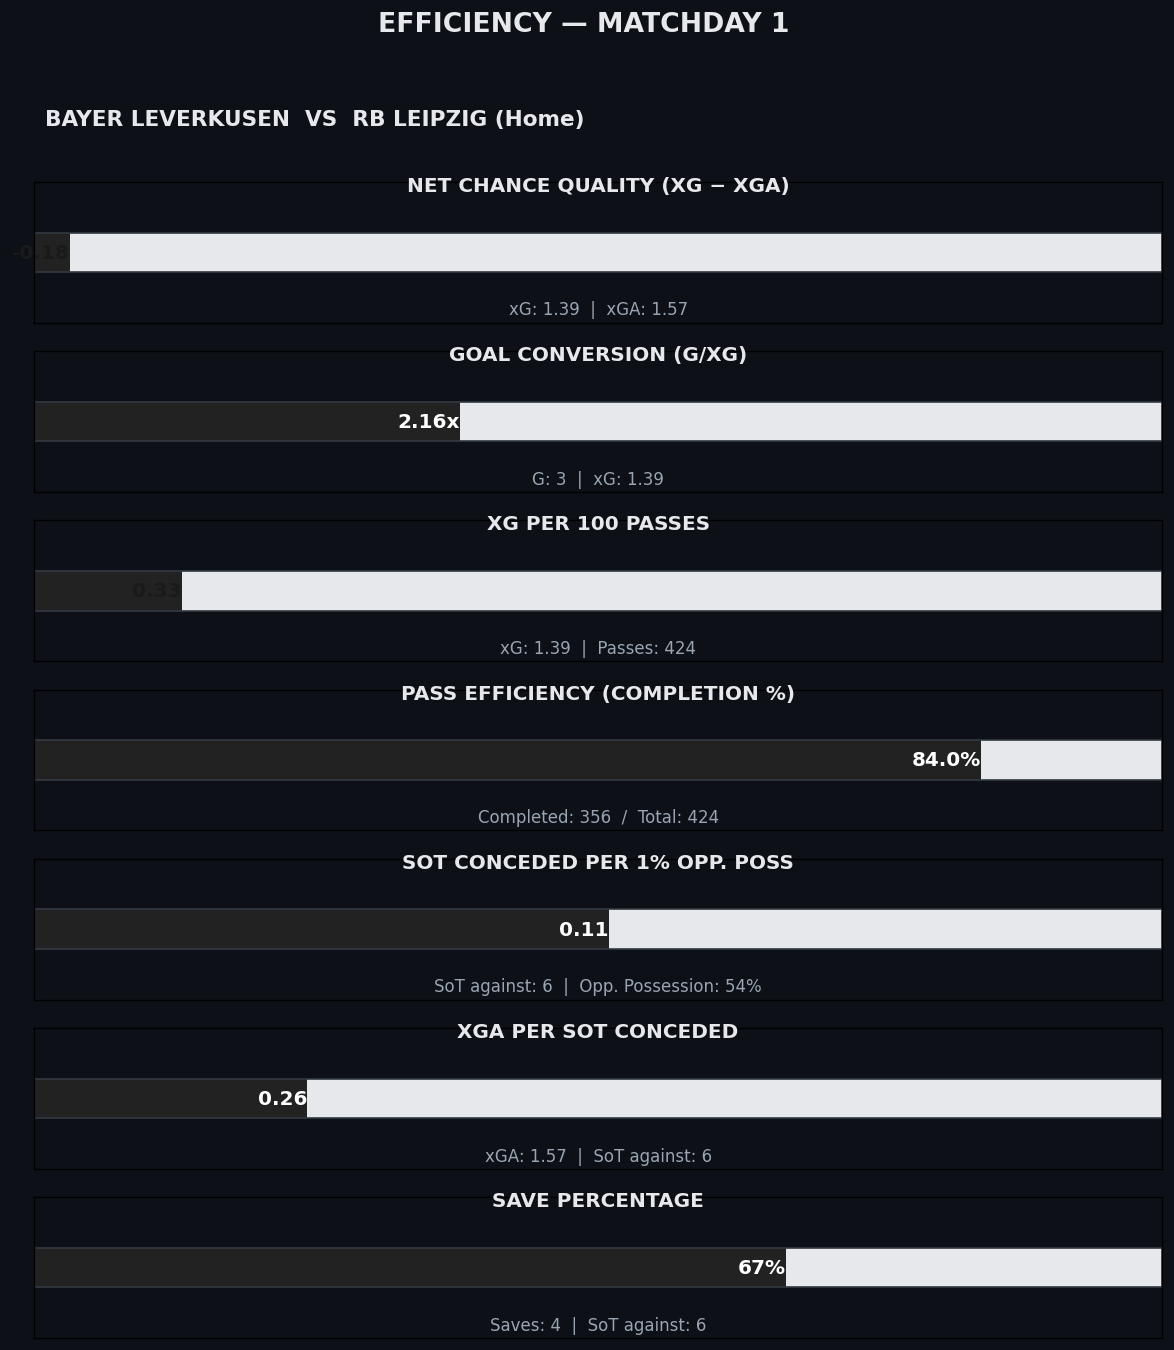

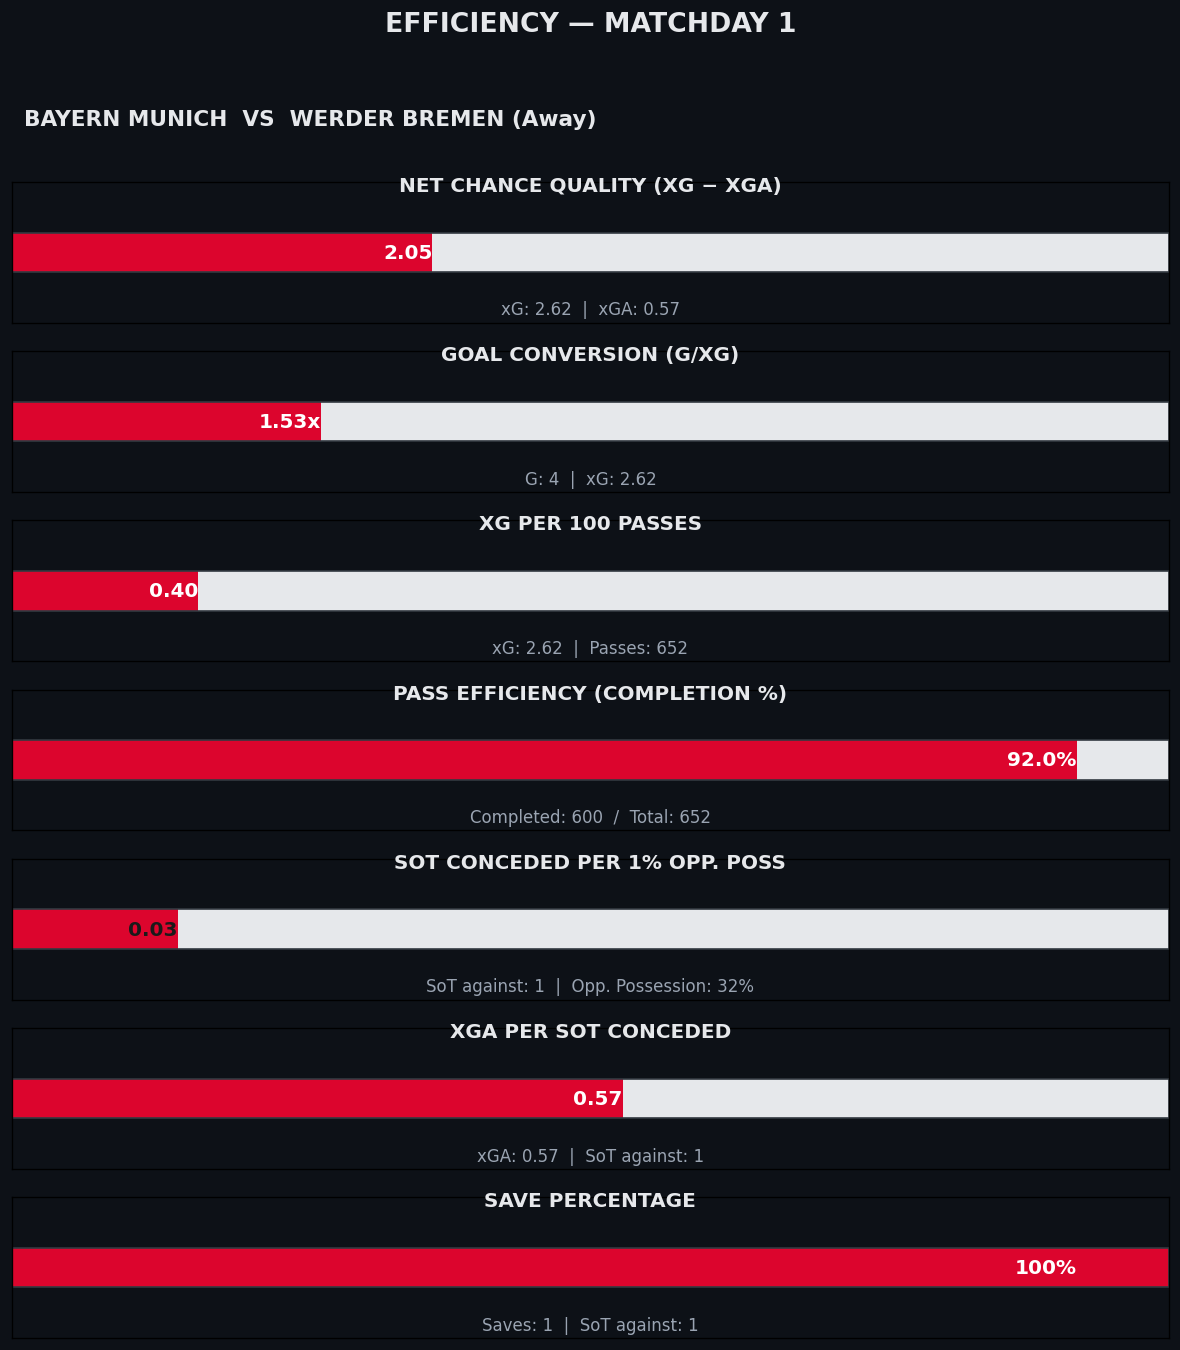

Saved 68 images to: c:\Users\Vex\Desktop\main\code\matchday1\efficiency_panels_split


In [7]:
# CELL 6 — Generate & save SEPARATE images per matchday (one per team)
# Purpose: iterate matchdays and write two PNGs per MD (one for each team).

def row_by_md(tdf, md):
    # Get the dict row for a given matchday; {} if missing
    r = tdf[tdf["matchday"] == md]
    return r.iloc[0].to_dict() if not r.empty else {}

# Determine max number of MDs available for both teams
N = min(len(lev), len(bay))
if N == 0:
    raise ValueError("No games found for one or both teams—cannot render panels.")

# Quick preview: render MD1 for both teams on screen
md0 = 1
lev_fig = draw_single_team_panel(md0, row_by_md(lev, md0), metrics, scales, TEAM_A, LEV_COLOR)
bay_fig = draw_single_team_panel(md0, row_by_md(bay, md0), metrics, scales, TEAM_B, BAY_COLOR)
plt.show()

# Save all matchdays as individual images per team
for md in range(1, N + 1):
    lev_fig = draw_single_team_panel(md, row_by_md(lev, md), metrics, scales, TEAM_A, LEV_COLOR)
    lev_path = os.path.join(OUTPUT_DIR, f"efficiency_{TEAM_A.lower().replace(' ', '_')}_md{md:02d}.png")
    lev_fig.savefig(lev_path, facecolor=lev_fig.get_facecolor(), bbox_inches="tight")
    plt.close(lev_fig)

    bay_fig = draw_single_team_panel(md, row_by_md(bay, md), metrics, scales, TEAM_B, BAY_COLOR)
    bay_path = os.path.join(OUTPUT_DIR, f"efficiency_{TEAM_B.lower().replace(' ', '_')}_md{md:02d}.png")
    bay_fig.savefig(bay_path, facecolor=bay_fig.get_facecolor(), bbox_inches="tight")
    plt.close(bay_fig)

print(f"Saved {2*N} images to: {os.path.abspath(OUTPUT_DIR)}")


In [8]:
# === Build matchday tables with xG/xGA + panel image link (one cell)
# Purpose: create CSV tables per team listing MD, date, opponent, result, xG/xGA, and the path to the saved panel image.

import os
import numpy as np
import pandas as pd
from datetime import datetime

# ---- edit if needed ----
CSV_PATH  = r"C:\Users\Vex\Desktop\main\dataset\matchday\clean_matchday_stat.csv"
TEAM_A    = "Bayer Leverkusen"
TEAM_B    = "Bayern Munich"
OUTPUT_DIR = "efficiency_panels_split"  # folder where per-team panels were saved

def _clean_num(v):
    # Normalize numeric strings to floats; keep NaN if invalid
    if isinstance(v, str):
        v = v.replace('%', '').replace(',', '').strip()
    return pd.to_numeric(v, errors='coerce')

def _parse_match_dt(row):
    # Rebuild datetime using season flip logic; tolerant to day/month formats
    day_month = str(row.get("Date_day","")).replace("-", ".").strip()
    hhmm = (str(row.get("Date_hour","00:00")).strip() or "00:00")
    if "." in day_month:
        parts = day_month.split(".", 1)
    else:
        parts = [p for p in day_month.split() if p]
    if len(parts) >= 2:
        d_str, m_str = parts[0], parts[1]
    else:
        d_str, m_str = "1", "7"
    try:
        d = int(float(d_str)); m = int(float(m_str))
    except Exception:
        d, m = 1, 7
    season = str(row.get("season_year","2023/2024"))
    start_year = int(season.split("/")[0]) if "/" in season else 2023
    year = start_year if m >= 7 else start_year + 1
    try:
        return datetime.strptime(f"{year:04d}-{m:02d}-{d:02d} {hhmm}", "%Y-%m-%d %H:%M")
    except Exception:
        return datetime(year, max(1,min(12,m)), max(1,min(28,d)), 0, 0)

def build_matchday_table_with_xg(csv_df, team_name, output_dir):
    """Assemble a chronological table for one team with score, xG/xGA, and path to panel image."""
    rows = []
    for _, row in csv_df.iterrows():
        home, away = row["home_team"], row["away_team"]
        home_g, away_g = _clean_num(row["home_score"]), _clean_num(row["away_score"])
        md_dt = _parse_match_dt(row)

        # Determine perspective and pull xG/xGA columns accordingly
        if home == team_name:
            venue = "Home"
            opp   = away
            gf, ga = home_g, away_g
            xg  = _clean_num(row.get("expected_goals_xg_home"))
            xga = _clean_num(row.get("expected_goals_xg_host"))
        elif away == team_name:
            venue = "Away"
            opp   = home
            gf, ga = away_g, home_g
            xg  = _clean_num(row.get("expected_goals_xg_host"))
            xga = _clean_num(row.get("expected_goals_xg_home"))
        else:
            continue  # not our team

        # Derive result tag + pretty score string
        if pd.isna(gf) or pd.isna(ga):
            result, score_str = "", ""
        else:
            result = "W" if gf > ga else ("L" if gf < ga else "D")
            score_str = f"{int(gf)}–{int(ga)}"

        rows.append({
            "match_dt": md_dt,
            "venue": venue,
            "opponent": opp,
            "GF": gf, "GA": ga,
            "score": score_str, "result": result,
            "xG": xg, "xGA": xga
        })

    # Chronological sort and MD numbering
    t = pd.DataFrame(rows).sort_values("match_dt").reset_index(drop=True)
    t["matchday"] = np.arange(1, len(t)+1)
    t["date"] = t["match_dt"].dt.strftime("%Y-%m-%d")

    # Panel path matches naming produced in CELL 6
    safe_team = team_name.lower().replace(" ", "_")
    t["panel_image"] = t["matchday"].apply(
        lambda md: os.path.join(output_dir, f"efficiency_{safe_team}_md{md:02d}.png")
    )

    # Mark existence for sanity check
    t["panel_exists"] = t["panel_image"].apply(os.path.exists)

    # Tidy column order for readability
    t = t[["matchday","date","venue","opponent","score","result","GF","GA","xG","xGA","panel_image","panel_exists"]]
    return t

# Build tables for both teams and write CSVs to OUTPUT_DIR
df = pd.read_csv(CSV_PATH)
lev_table = build_matchday_table_with_xg(df, TEAM_A, OUTPUT_DIR)
bay_table = build_matchday_table_with_xg(df, TEAM_B, OUTPUT_DIR)

lev_csv = os.path.join(OUTPUT_DIR, "leverkusen_matchday_list_with_xg.csv")
bay_csv = os.path.join(OUTPUT_DIR, "bayern_matchday_list_with_xg.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)
lev_table.to_csv(lev_csv, index=False)
bay_table.to_csv(bay_csv, index=False)

print("Leverkusen table saved to:", lev_csv)
print("Bayern table saved to:", bay_csv)

# Console previews (first 10 rows) with key columns
display_cols = ["matchday","date","venue","opponent","score","result","xG","xGA","panel_exists"]
print("\nLeverkusen preview:\n", lev_table[display_cols].head(10).to_string(index=False))
print("\nBayern preview:\n", bay_table[display_cols].head(10).to_string(index=False))


Leverkusen table saved to: efficiency_panels_split\leverkusen_matchday_list_with_xg.csv
Bayern table saved to: efficiency_panels_split\bayern_matchday_list_with_xg.csv

Leverkusen preview:
  matchday       date venue           opponent score result   xG  xGA  panel_exists
        1 2023-08-19  Home         RB Leipzig   3–2      W 1.39 1.57          True
        2 2023-08-26  Away B. Monchengladbach   3–0      W 3.09 0.72          True
        3 2023-09-02  Home          Darmstadt   5–1      W 3.48 0.95          True
        4 2023-09-15  Away      Bayern Munich   2–2      D 1.83 2.62          True
        5 2023-09-24  Home         Heidenheim   4–1      W 3.48 0.10          True
        6 2023-09-30  Away              Mainz   3–0      W 0.88 0.69          True
        7 2023-11-04  Away         Hoffenheim   3–2      W 1.46 1.82          True
        8 2023-11-12  Home       Union Berlin   4–0      W 2.51 0.07          True
        9 2023-11-25  Away      Werder Bremen   3–0      W 1.11